# MobileHCI 2018 tutorial: Machine Learning for Intelligent Mobile User Interfaces using Keras

### Setup: dependencies, versions, getting data

In [5]:
# -*- coding: utf-8 -*-

## By Abdallah El Ali
## MobileHCI 2018 tutorial: Machine Learning for Intelligent Mobile User Interfaces using Keras.

## Some code adapted from: GUILLAUME CHEVALIER https://github.com/guillaume-chevalier/LSTM-Human-Activity-Recognition

import tensorflow as tf
from tensorflow.python.framework import graph_util, graph_io
from tensorflow.python.tools import freeze_graph

from keras.models import Sequential, load_model, model_from_json
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, LSTM, LSTMCell, Bidirectional, TimeDistributed, InputLayer, ConvLSTM2D
from keras import optimizers
from keras import backend as K

from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneGroupOut
# http://scikit-learn.org/stable/modules/generated/sklearn.model_selection.LeaveOneGroupOut.html#sklearn.model_selection.LeaveOneGroupOut

from scipy import stats
import scipy.io

import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm
import seaborn as sns
import pickle
import math
# from mpl_toolkits.mplot3d import Axes3D
import pylab
import os
import os.path as osp
import wget
import zipfile
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.5)

# graph = tf.get_default_graph()
K.clear_session()

/Users/aelali/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._conv import register_converters as _register_converters
/Users/aelali/anaconda/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
/Users/aelali/anaconda/lib/python2.7/site-packages/h5py/__init__.py:45: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import h5a, h5d, h5ds, h5f, h5fd, h5g, h5r, h5s, h5t, h5p, h5z
/Users/aelali/anaconda/lib/python2.7/site-packages/h5py/_hl/group.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .. import h5g, h5i, h5o, h

/Users/aelali/anaconda/lib/python2.7/site-packages/sklearn/utils/extmath.py:26: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sparsefuncs_fast import csr_row_norms
/Users/aelali/anaconda/lib/python2.7/site-packages/sklearn/metrics/cluster/supervised.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .expected_mutual_info_fast import expected_mutual_information
/Users/aelali/anaconda/lib/python2.7/site-packages/sklearn/metrics/pairwise.py:30: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .pairwise_fast import _chi2_kernel_fast, _sparse_manhattan
Using TensorFlow backend.
/Users/aelali/anaconda/lib/python2.7/site-packages/sklearn/utils/random.py:10: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._random import sample_without_replacement
/Users/aelal

In [13]:
## install all necessary python 2.7 packages
# !pip3 install -r requirements.txt

In [7]:
## convert Jupyter notebook to a README for GitHub repo's main page
!jupyter nbconvert --to markdown mobilehci2018_keras_har_tutorial.ipynb
!mv mobilehci2018_keras_har_tutorial.md README.md

[NbConvertApp] Converting notebook mobilehci2018_keras_har_tutorial.ipynb to markdown
[NbConvertApp] Support files will be in mobilehci2018_keras_har_tutorial_files/
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_har_tutorial_files
[NbConvertApp] Making directory mobilehci2018_keras_h

In [2]:
# If GPU is not available: 
# GPU_USE = '/cpu:0'
# config = tf.ConfigProto(device_count = {"GPU": 0})


# If GPU is available: 
config = tf.ConfigProto()
config.log_device_placement = True
config.allow_soft_placement = True
config.gpu_options.allocator_type = 'BFC'


# Limit the maximum memory used
# config.gpu_options.per_process_gpu_memory_fraction = 0.1

# set session config
tf.keras.backend.set_session(tf.Session(config=config))

In [15]:
## check tensorflow version
!python3 -W ignore -c 'import tensorflow as tf; print(tf.__version__)'  # for Python 2

## check python version
!python3 --version

## check matplotlib version
!python3 -c 'import matplotlib; print(matplotlib.__version__, matplotlib.__file__)'


## gradle TF build repo
# https://mvnrepository.com/artifact/org.tensorflow/tensorflow-android/1.5.0-rc1

1.9.0
Python 3.6.5
2.2.3 /home/abdo/.local/lib/python3.6/site-packages/matplotlib/__init__.py


In [14]:
## wget UCD dataset + all .npy files and dump into ./data dir

if not os.path.exists('./data'):
    os.makedirs('./data')

if not os.path.exists('./accel'):
    os.makedirs('./accel')

!wget -P ./data 'http://abdoelali.com/data/mobilehci2018_tutorial_data.zip'
!wget -P ./accel 'http://abdoelali.com/data/accel_only.zip'

--2018-08-29 09:35:52--  http://abdoelali.com/data/mobilehci2018_tutorial_data.zip
Resolving abdoelali.com (abdoelali.com)... 160.153.1.1
Connecting to abdoelali.com (abdoelali.com)|160.153.1.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 273858391 (261M) [application/zip]
Saving to: ‘./data/mobilehci2018_tutorial_data.zip.1’

mobilehci2018_tutor 100%[===================>] 261.17M  22.4MB/s    in 18s     

2018-08-29 09:36:11 (14.2 MB/s) - ‘./data/mobilehci2018_tutorial_data.zip.1’ saved [273858391/273858391]

--2018-08-29 09:36:11--  http://abdoelali.com/data/accel_only.zip
Resolving abdoelali.com (abdoelali.com)... 160.153.1.1
Connecting to abdoelali.com (abdoelali.com)|160.153.1.1|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 86931679 (83M) [application/zip]
Saving to: ‘./accel/accel_only.zip.1’

accel_only.zip.1    100%[===================>]  82.90M  18.4MB/s    in 4.2s    

2018-08-29 09:36:15 (19.6 MB/s) - ‘./accel/accel_only

In [15]:
## unzip and delete files
with zipfile.ZipFile('./data/mobilehci2018_tutorial_data.zip','r') as zipref:
    zipref.extractall('./data/')
os.remove('./data/mobilehci2018_tutorial_data.zip')

with zipfile.ZipFile('./accel/accel_only.zip','r') as zipref:
    zipref.extractall('./accel/')
os.remove('./accel/accel_only.zip')

### Preprocressing

In [16]:
## let's first define some function we will use

## setting up a random seed for reproducibility
random_seed = 611
np.random.seed(random_seed)

## matplotlib inline
plt.style.use('ggplot')

## defining function for loading our dataset
def readData(filePath):
    # attributes of the dataset
    columnNames = ['user_id','activity','timestamp','x-axis','y-axis','z-axis']
    data = pd.read_csv(filePath,header = None, names=columnNames,na_values=';')
    return data[0:2000]

## feature normalization using standardization (or Z-score normalization)
## (feature - mean)/stdiv
def featureNormalizeZscore(data):
    mu = np.mean(data,axis=0)
    sigma = np.std(data,axis=0)
    return (data-mu)/sigma

# find the min and max values for each column
def dataset_minmax(data):
    minmax = list()
    for i in range(len(data[0])):
        col_values = [row[i] for row in data]
        value_min = min(col_values)
        value_max = max(col_values)
        minmax.append([value_min, value_max])
    return minmax
 
# rescale dataset columns to the range 0-1
def normalize_dataset(data, minmax):
    for row in data:
        for i in range(len(row)):
            row[i] = (row[i] - minmax[i][0]) / (minmax[i][1] - minmax[i][0])
            
## compute Euclidean Norm
def featureNormalizeEuclidean(data):
    return np.sqrt(sum(data^2))

## defining the function to plot a single axis data
def plotAxis(axis,x,y,title):
    axis.plot(x,y)
    axis.set_title(title)
    axis.xaxis.set_visible(False)
    axis.set_ylim([min(y)-np.std(y),max(y)+np.std(y)])
    axis.set_xlim([min(x),max(x)])
    axis.grid(True)

## defining a function to plot the data for a given activity
def plotActivity(activity,data):
    fig,(ax0,ax1,ax2) = plt.subplots(nrows=3, figsize=(15,10),sharex=True)
    plotAxis(ax0,data['timestamp'],data['x-axis'],'x-axis')
    plotAxis(ax1,data['timestamp'],data['y-axis'],'y-axis')
    plotAxis(ax2,data['timestamp'],data['z-axis'],'z-axis')
    plt.subplots_adjust(hspace=0.2)
    fig.suptitle(activity)
    plt.subplots_adjust(top=0.9)
    plt.show()

## defining a window function for segmentation purposes
def windows(data,size):
    start = 0
    while start< data.count():
        yield int(start), int(start + size)
        start+= (size/2)    

## our segmentation function to get streams of 90 samples in each timestep 
def segment_signal(data, window_size = 90):
    segments = np.empty((0,window_size,6))
    labels= np.empty((0))
    subjects = np.empty((0))

    for (start, end) in windows(data['activity'],window_size):
        x = data['acc_x'][start:end]
        y = data['acc_y'][start:end]
        z = data['acc_z'][start:end]
        p = data['gyr_x'][start:end]
        q = data['gyr_y'][start:end]
        r = data['gyr_z'][start:end]

        if(len(data['activity'][start:end])==window_size):
            segments = np.vstack([segments,np.dstack([x,y,z,p,q,r])])
            if labels is not None:
                labels = np.append(labels,stats.mode(data['activity'][start:end])[0][0])
            subjects = np.append(subjects,stats.mode(data['subject'][start:end])[0][0])
    return segments, labels, subjects

In [24]:
## read in the USC-HAD data. here we use activity number since activities have missing/incorrect labels
DIR = './data/USC-HAD/data/'

# activity = []
subject = []
# age = []
act_num = []
sensor_readings = []

def read_dir(directory):
    for path, subdirs, files in os.walk(DIR):
        for name in files:
            if name.endswith('.mat'):
                mat = scipy.io.loadmat(os.path.join(path, name))
#                 activity.append(mat['activity'])
                subject.extend(mat['subject'])
#                 age.extend(mat['age'])
                sensor_readings.append(mat['sensor_readings'])

                if mat.get('activity_number') is None:
                    act_num.append('11')
                else:
                    act_num.append(mat['activity_number'])
    return subject, act_num, sensor_readings

## Corrupt datapoint:
# act_num[258] = '11'            
subject, act_num, sensor_readings = read_dir(DIR)

In [25]:
## get acc + gyr sensor readings and put in df (dataframe)
acc_x = []
acc_y = []
acc_z = []
gyr_x = []
gyr_y = []
gyr_z = []

act_label = []
subject_id = []
df = None

for i in range(840):
    for j in sensor_readings[i]:   
        acc_x.append(j[0]) # acc_x
        acc_y.append(j[1]) # acc_y
        acc_z.append(j[2]) # acc_z
        gyr_x.append(j[3]) # gyr_x
        gyr_y.append(j[4]) # gyr_y
        gyr_z.append(j[5]) # gyr_z
        act_label.append(act_num[i])
        subject_id.append(subject[i])
        
df = pd.DataFrame({'subject':subject_id,'acc_x':acc_x,'acc_y':acc_y,'acc_z':acc_z,'gyr_x':gyr_x,'gyr_y':gyr_y,'gyr_z':gyr_z,'activity':act_label})                   

df = df[['subject','acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z','activity']]

df.loc[df['activity'] == '1', 'activity'] = 'Walking Forward'
df.loc[df['activity'] == '2', 'activity'] = 'Walking Left'
df.loc[df['activity'] == '3', 'activity'] = 'Walking Right'
df.loc[df['activity'] == '4', 'activity'] = 'Walking Upstairs'
df.loc[df['activity'] == '5', 'activity'] = 'Walking Downstairs'
df.loc[df['activity'] == '6', 'activity'] = 'Running Forward'
df.loc[df['activity'] == '7', 'activity'] = 'Jumping Up'
df.loc[df['activity'] == '8', 'activity'] = 'Sitting'
df.loc[df['activity'] == '9', 'activity'] = 'Standing'
df.loc[df['activity'] == '10', 'activity'] = 'Sleeping'
df.loc[df['activity'] == '11', 'activity'] = 'Elevator Up'
df.loc[df['activity'] == '12', 'activity'] = 'Elevator Down'

## these are the 12 classes we want to recognize!
df['activity'].unique() 

## print size of dataset
print('df size ' + str(len(df)))

df size 2811490


In [10]:
## use only for collapsing / reducing output classes

# df2 = df

# df2.loc[df2['activity'] == 'Walking Forward', 'activity'] = 'Walking'
# df2.loc[df2['activity'] == 'Walking Left', 'activity'] = 'Walking'
# df2.loc[df2['activity'] == 'Walking Right', 'activity'] = 'Walking'

In [21]:
## inspect the dataframe
print(df[1:10])

  subject     acc_x     acc_y     acc_z      gyr_x      gyr_y      gyr_z  \
1      10  1.008259 -0.051760 -0.017609  20.392937   3.212698  17.658215   
2      10  0.991090 -0.033664 -0.024929  18.781609   1.598059  18.463879   
3      10  0.987656 -0.033664 -0.017609  16.767448  -1.219244  18.061047   
4      10  0.970487 -0.004711  0.008012  15.961784  -4.441900  14.838390   
5      10  0.949885 -0.004711  0.029973  15.558952  -8.067389  14.032726   
6      10  0.939583  0.017004  0.059254  12.336296 -12.498541  11.212902   
7      10  0.939583  0.053195  0.103176  10.724968 -16.526861   7.587414   
8      10  0.936149  0.071291  0.132458  10.724968 -20.555182   3.961926   
9      10  0.936149  0.082148  0.147098   9.113640 -22.569342   1.544933   

          activity  
1  Walking Forward  
2  Walking Forward  
3  Walking Forward  
4  Walking Forward  
5  Walking Forward  
6  Walking Forward  
7  Walking Forward  
8  Walking Forward  
9  Walking Forward  


### Explore your dataset (through visualization)

acc_x
-3.3526623249053955
6.931558132171631
0.7827994823243803


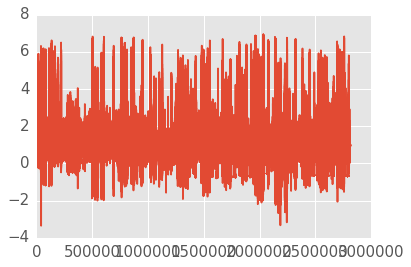

acc_y
-6.417827129364014
4.949891567230225
0.20133661876515005


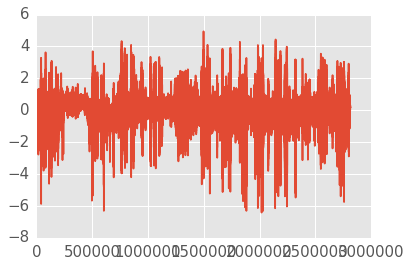

acc_z
-5.416336536407471
4.539283275604248
-0.061909986305492014


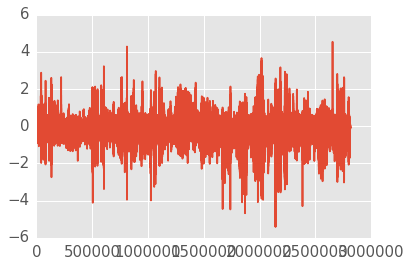

gyr_x
-770.8486328125
856.3609008789062
-0.41388714539642746


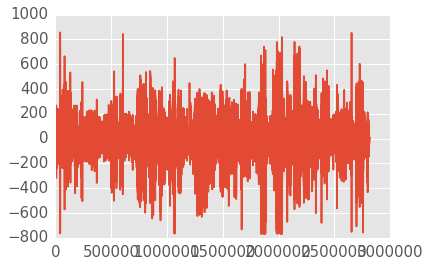

gyr_y
-775.4454345703125
559.6139526367188
-0.3517485338820081


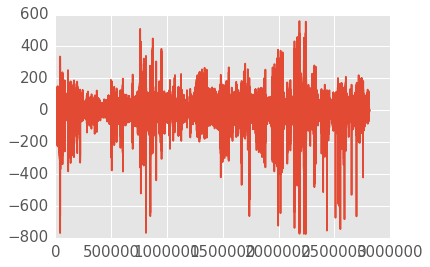

gyr_z
-808.1836547851562
816.5776977539062
-0.17479588110103636


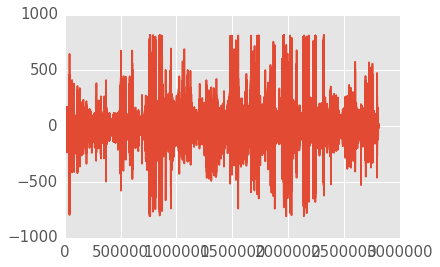

In [20]:
## explore your overall accel and gyro values: min, max, mean, and plot over time

''' 
## USC-HAD Sensors

From the UbiComp'12 paper:
"Based on the above considerations, we use an off-the-shelf sensing platform called MotionNode to capture human activity signals 
and build our dataset. MotionNode is a 6-DOF inertial measurement unit (IMU) specifically designed for human motion sensing 
applications (see Figure 2) [2]. Each MotionNode itself is a multi-modal sensor that integrates a 3-axis accelerometer, 
3-axis gyroscope, and a 3-axis mag- netometer. The measurement range is ±6g and ±500dps for each axis of accelerometer and gyroscope 
respectively. Although body limbs and extremities can exhibit up to ±12g in acceleration, points near the torso 
and hip experience no more than ±6g range in acceleration [6]."

• MotionNode is extremely small in size (35mm×35mm× 15mm) and lightweight enough (14g) to wear comfort- ably for long period of time. 
This feature makes MotionN- ode unobtrusive and thus perfect as a wearable device.
• Compared to the accelerometer and gyroscope embedded in the smartphones (e.g. iPhone 4G), the integrated sen- sors have higher 
resolution (0.001g ± 10% for accelerom- eter, 0.5◦/second for gyroscope) and wider sensing ranges. In addition, MotionNode 
is gyro-stablized and well cali- brated such that the readings are accurate and reliable.
• The highest sampling rate can reach 100Hz. This sampling frequency is much higher than the one used in some of the existing 
datasets [23] [21].

**********************************************
Section 1: Device Configuration
**********************************************

1. Device Type: MotionNode
2. Sampling rate: 100Hz (or 10,000 microseconds)
3. Accelerometer range: +-6g
4. Gyroscope range: +-500dps

For sensor_readings field, it consists of 6 readings:
From left to right:
1. acc_x, w/ unit g (gravity)
2. acc_y, w/ unit g
3. acc_z, w/ unit g
4. gyro_x, w/ unit dps (degrees per second)
5. gyro_y, w/ unit dps
6. gyro_z, w/ unit dps

BMI MotionNode sensor spec sheet: https://www.motionnode.com/technology.html 

============
## Android Nexus 5 sensors

For Android Nexus 5 sensor specs, check: https://www.bosch-sensortec.com/bst/products/all_products/bmi160

'''

## explore your overall accel and gyro values: min, max, mean, and plot over time

## accelerometer 
print('acc_x')
print(min(df['acc_x']))
print(max(df['acc_x']))
print(np.mean(df['acc_x']))
plt.plot(df['acc_x'])
plt.show()

print('acc_y')
print(min(df['acc_y']))
print(max(df['acc_y']))
print(np.mean(df['acc_y']))
plt.plot(df['acc_y'])
plt.show()

print('acc_z')
print(min(df['acc_z']))
print(max(df['acc_z']))
print(np.mean(df['acc_z']))
plt.plot(df['acc_z'])
plt.show()

## gyroscope 
print('gyr_x')
print(min(df['gyr_x']))
print(max(df['gyr_x']))
print(np.mean(df['gyr_x']))
plt.plot(df['gyr_x'])
plt.show()

print('gyr_y')
print(min(df['gyr_y']))
print(max(df['gyr_y']))
print(np.mean(df['gyr_y']))
plt.plot(df['gyr_y'])
plt.show()

print('gyr_z')
print(min(df['gyr_z']))
print(max(df['gyr_z']))
print(np.mean(df['gyr_z']))
plt.plot(df['gyr_z'])
plt.show()

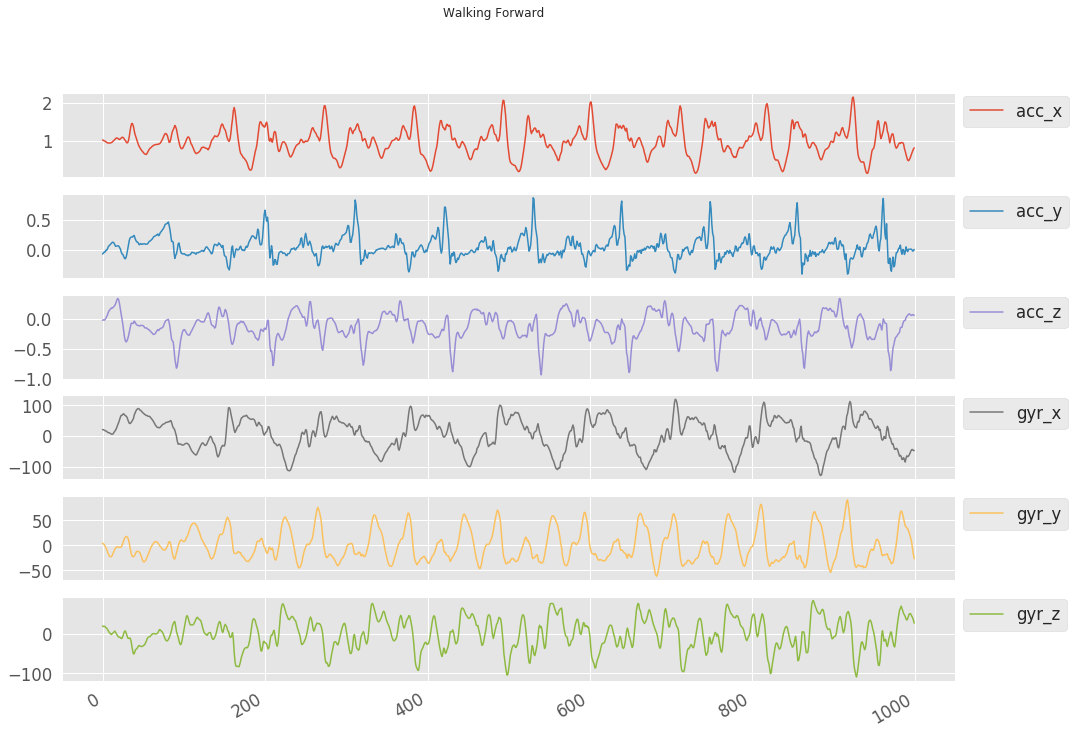

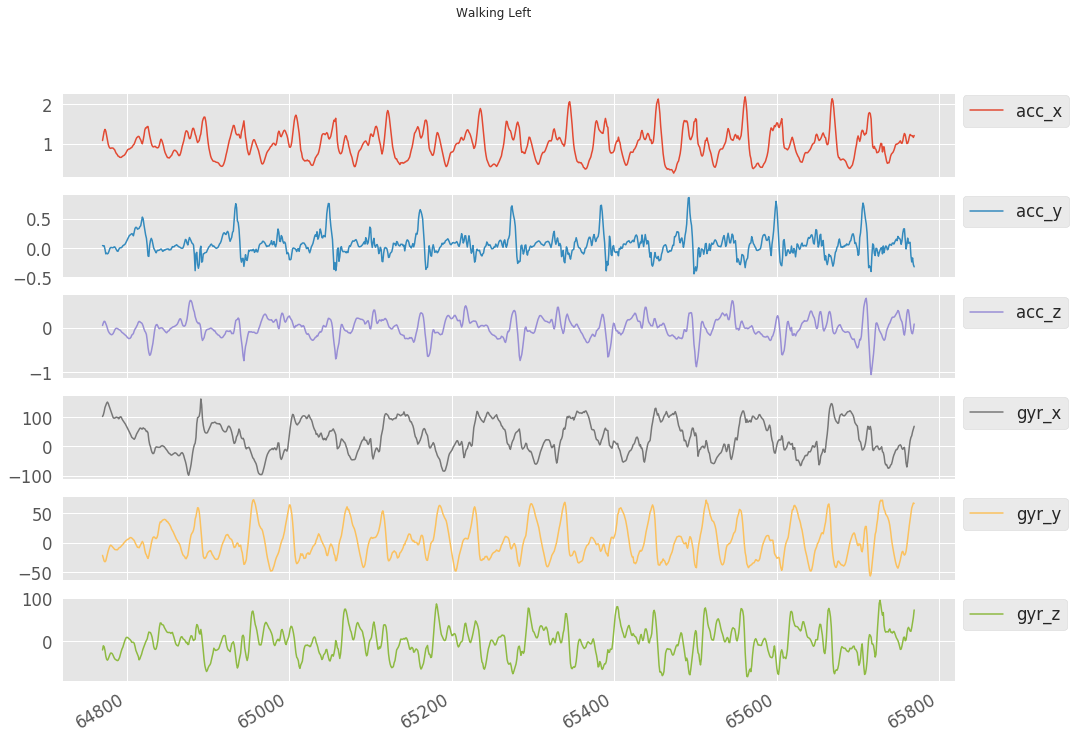

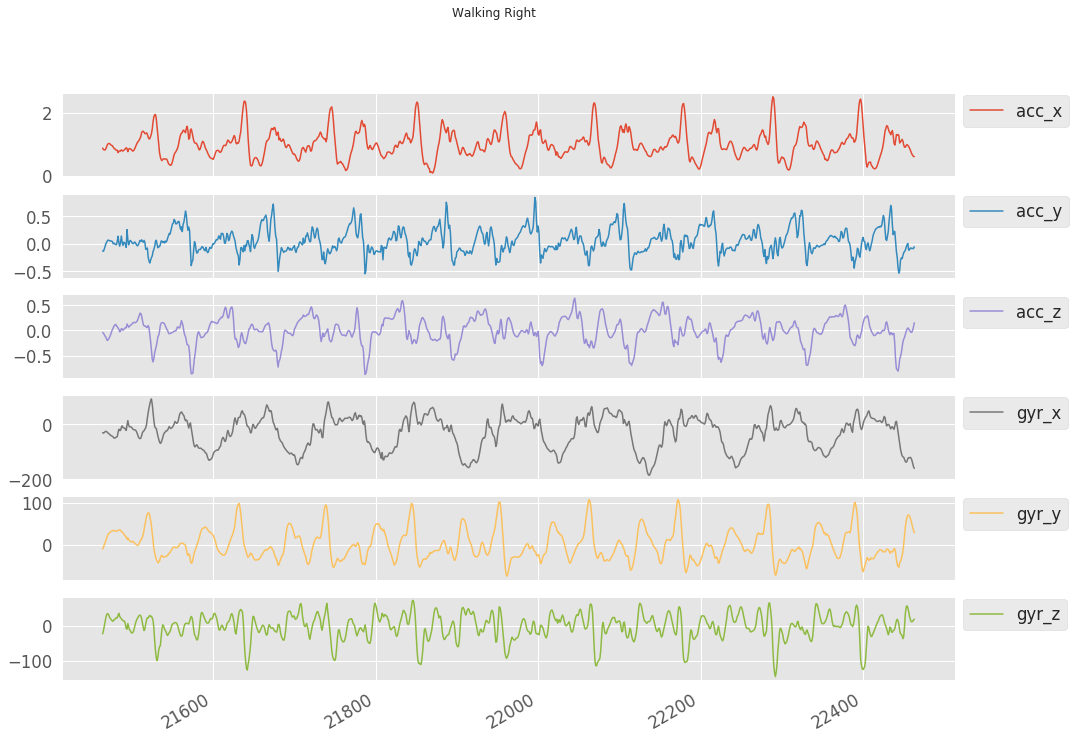

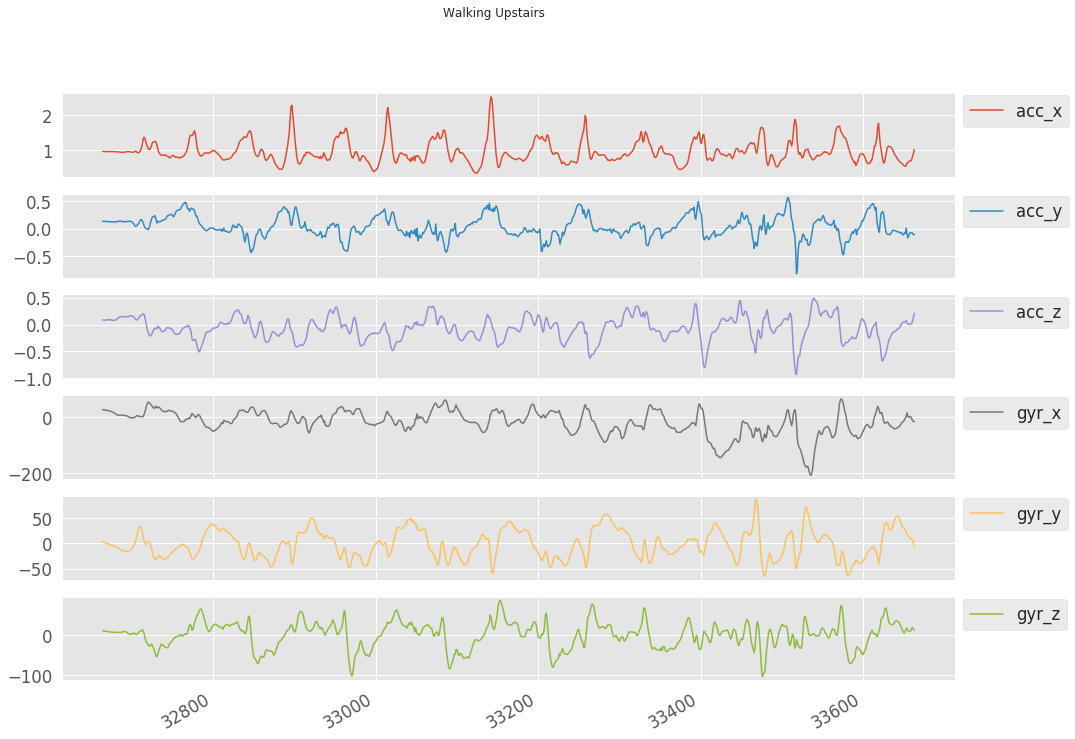

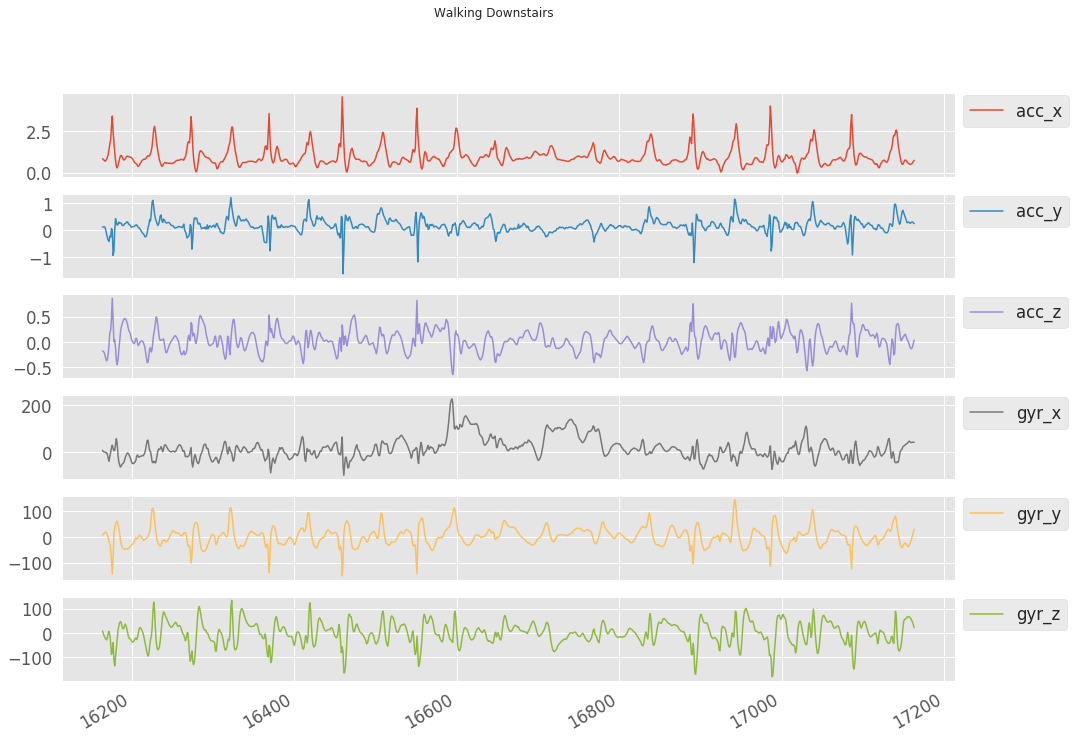

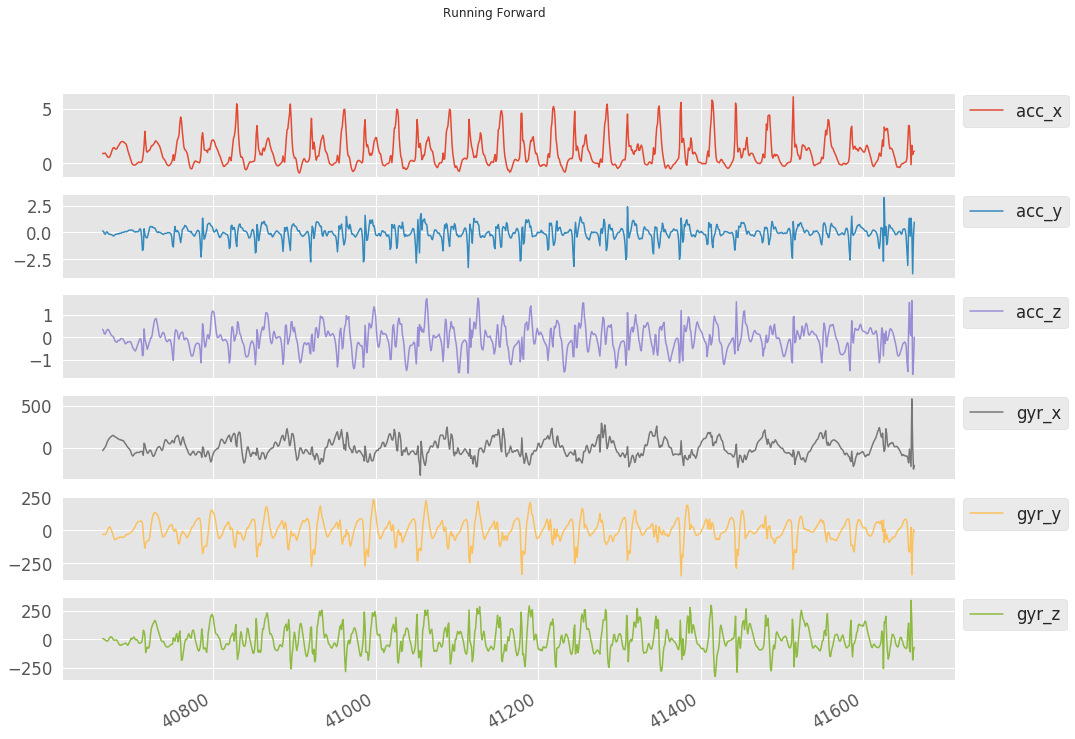

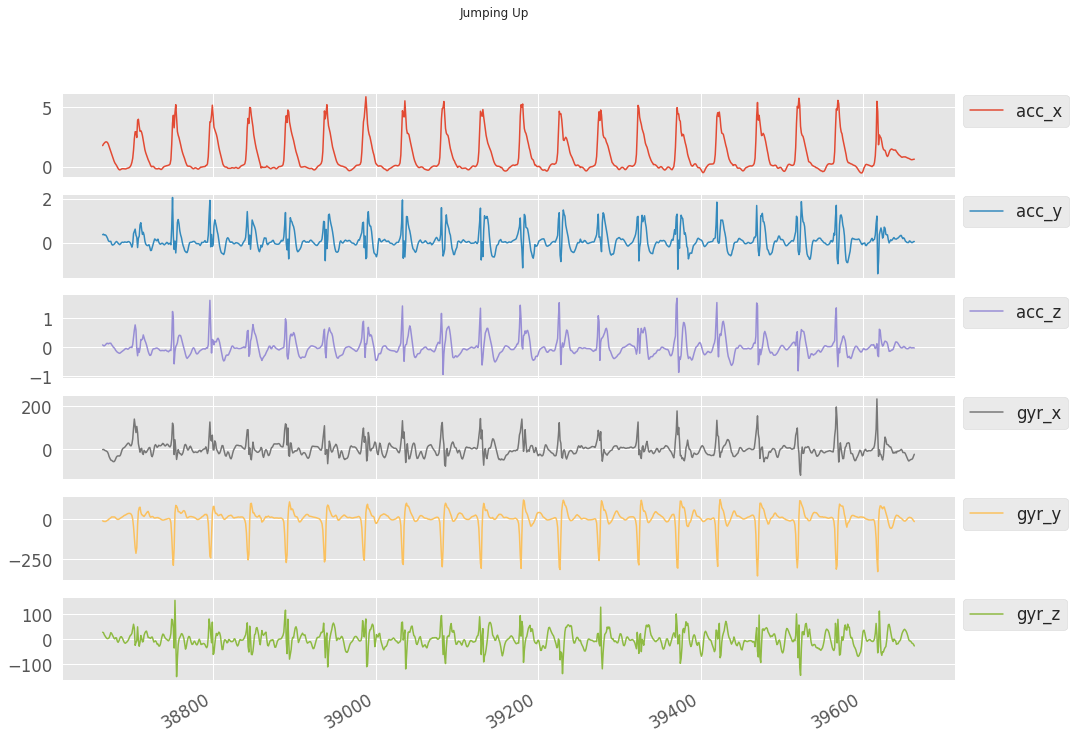

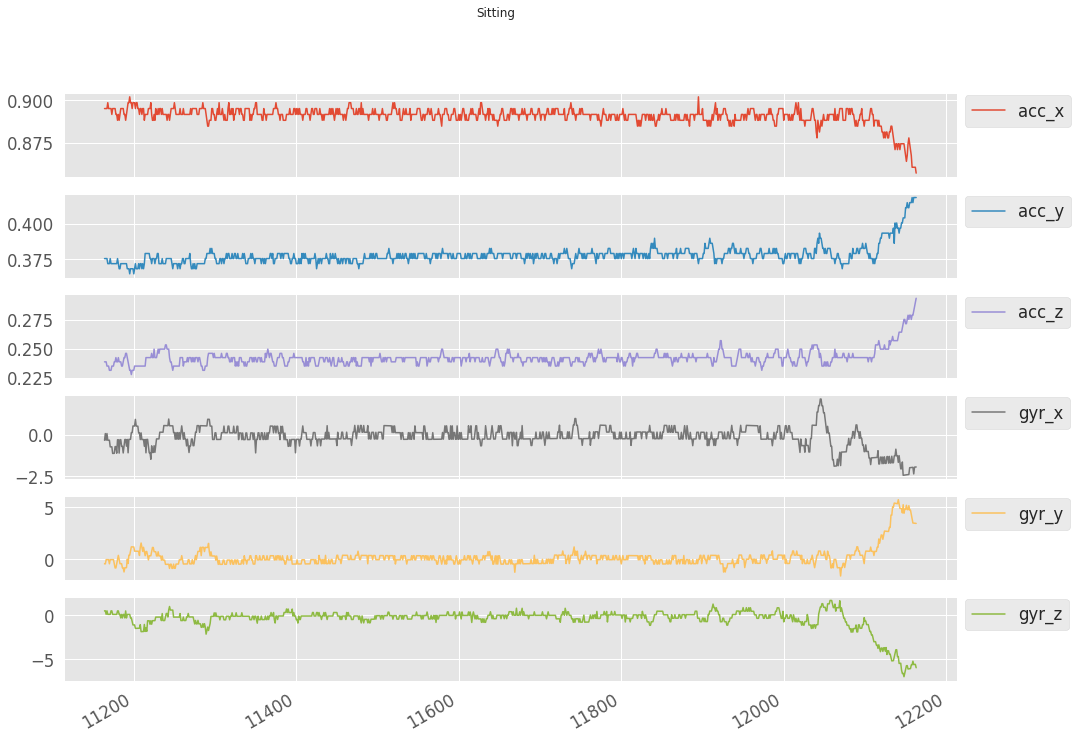

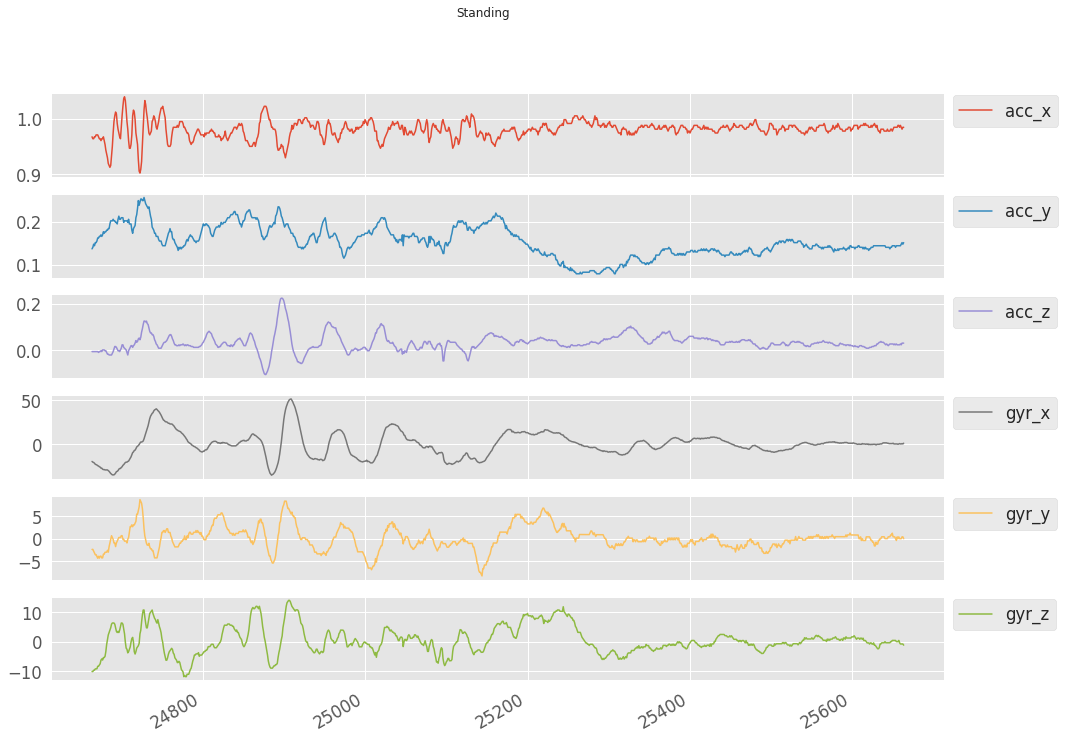

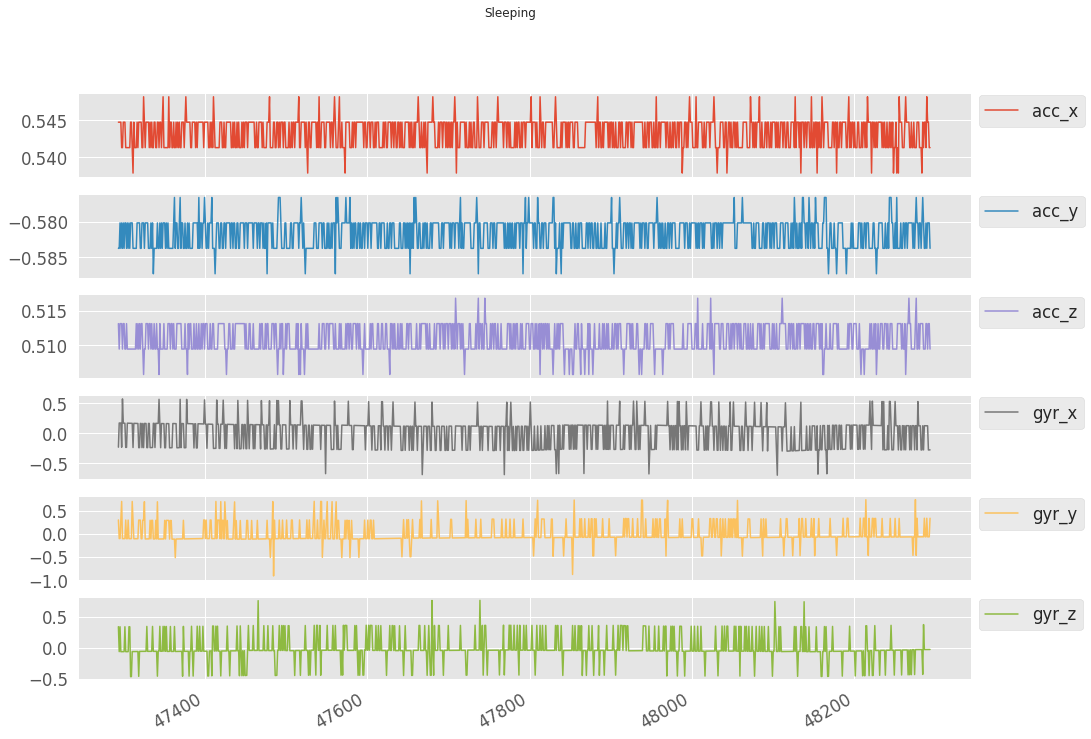

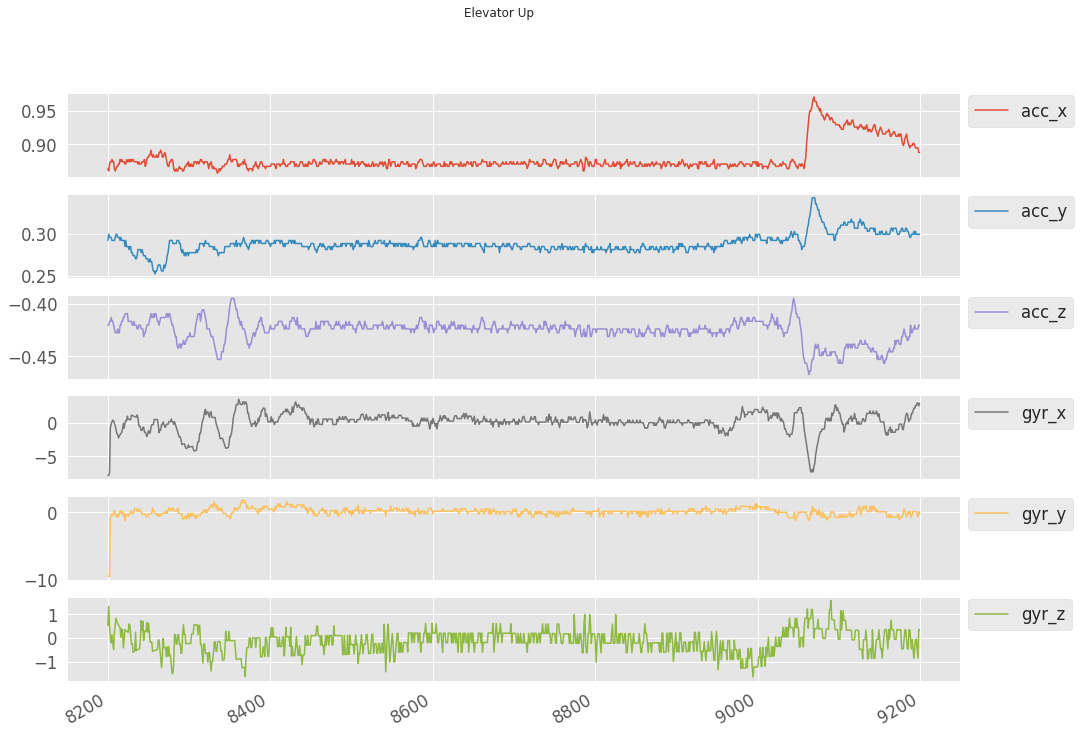

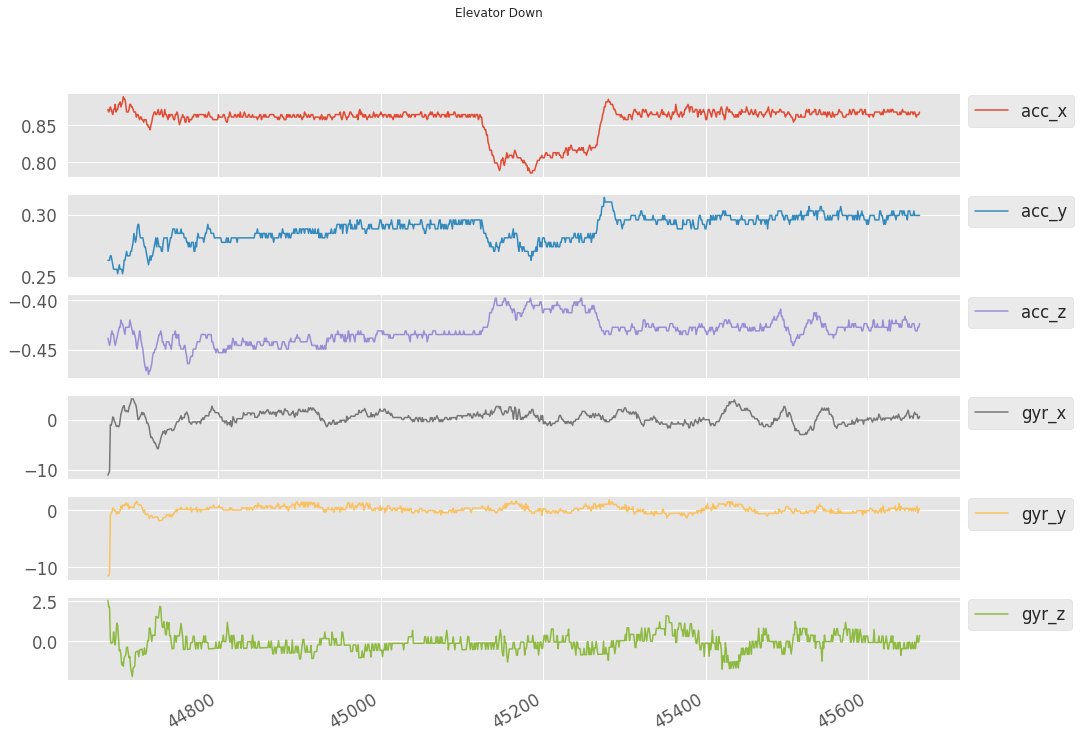

In [22]:
## set up a plots dir

plot_dir = './plots/activity_vis/'

os.makedirs(plot_dir, exist_ok=True)
    
## two functions below to plot your data, and save them to disk
def plot_activity(activity, df,i=0, j=100):
    data = df[df['activity'] == activity][['acc_x', 'acc_y', 'acc_z', 'gyr_x', 'gyr_y', 'gyr_z']][i:j]
    axis = data.plot(subplots=True, figsize=(16, 12), 
                     title=activity)
    for ax in axis:
        ax.legend(loc='lower left', bbox_to_anchor=(1.0, 0.5))
        
    if not os.path.isdir(plot_dir):
        os.makedirs(plot_dir)

    plt.savefig(plot_dir + str(activity) + '.pdf',bbox_inches='tight')
        
def plot_datasets(df,i=0,j=1000):
    plot_activity('Walking Forward', df,i,j)
    plot_activity('Walking Left', df,i,j)
    plot_activity('Walking Right', df,i,j)
    plot_activity('Walking Upstairs', df,i,j)
    plot_activity('Walking Downstairs', df,i,j)
    plot_activity('Running Forward', df,i,j)
    plot_activity('Jumping Up', df,i,j)
    plot_activity('Sitting', df,i,j)
    plot_activity('Standing', df,i,j)
    plot_activity('Sleeping', df,i,j)
    plot_activity('Elevator Up', df,i,j)
    plot_activity('Elevator Down', df,i,j)

plot_datasets(df)

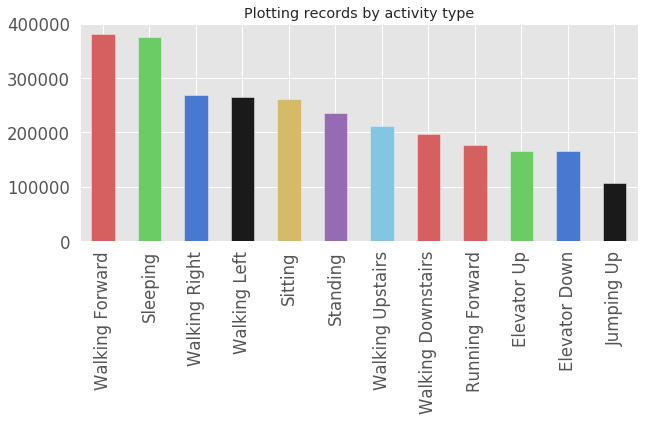

In [28]:
## check class districtions, and save fig to disk
df['activity'].value_counts().plot(kind='bar', color=['r','g','b','k','y','m','c'], title='Plotting records by activity type', figsize=(10, 4),align='center');
plt.savefig(plot_dir + 'sample_dist.pdf', bbox_inches='tight')

In [29]:
## print the value counts for each activity
print(df['activity'].value_counts())

Walking Forward       381400
Sleeping              375000
Walking Right         269700
Walking Left          264600
Sitting               261500
Standing              236000
Walking Upstairs      211800
Walking Downstairs    197400
Running Forward       176500
Elevator Up           165491
Elevator Down         164999
Jumping Up            107100
Name: activity, dtype: int64


In [3]:
## UNCOMMENT below line for segmenting the signal in overlapping windows of 90 samples with 50% overlap
# segments, labels, subjects = segment_signal(df)

## COMMENT below segments + labels files if you want to segment afresh . open a file, where you stored the pickled data
segments = pickle.load(open('./data/segments_90_logo.p', 'rb'), encoding='latin1')
labels = pickle.load(open('./data/labels_90_logo.p','rb'), encoding='latin1')
subjects = pickle.load(open('./data/subjects_90_logo.p','rb'),encoding='latin1')

## dump information to that file (UNCOMMENT to save fresh segmentation!)
# pickle.dump(segments, open( './data/segments_90_logo.p','wb'))
# pickle.dump(labels, open( './data/labels_90_logo.p','wb'))
# pickle.dump(subjects, open( './data/subjects_90_logo.p','wb'))

# segments, labels, subjects = segment_signal(df)
groups = np.array(subjects)

logo = LeaveOneGroupOut()
logo.get_n_splits(segments, labels, groups)

## defining parameters for the input and network layers
## we are treating each segmeent or chunk as a 2D image (90 X 3)
numOfRows = segments.shape[1]
numOfColumns = segments.shape[2]

## reshaping the data for network input
reshapedSegments = segments.reshape(segments.shape[0], numOfRows, numOfColumns,1)
## (observations, timesteps, features (x,y,z), channels)

# categorically defining the classes of the activities
labels = np.asarray(pd.get_dummies(labels),dtype = np.int8)

### Config your ConvLSTM

In [4]:
## ConvLSTM net hyperparameters

numChannels = 1
numFilters = 128 # number of filters in Conv2D layer
# kernal size of the Conv2D layer
kernalSize1 = 2
# max pooling window size
poolingWindowSz = 2
# number of filters in fully connected layers
numNueronsFCL1 = 128
numNueronsFCL2 = 128
# number of epochs
Epochs = 10
# batchsize
batchSize = 10
# number of total clases
numClasses = labels.shape[1]
# dropout ratio for dropout layer
dropOutRatio = 0.2

## number of total clases
numClasses = labels.shape[1]
print(labels.shape)
print(numClasses)

# k = []

# for i in range(len(labels)):
#     if labels[i][0] == 1: 
#         k.append(labels[i])
# print(len(k))

# print(labels.shape)

(62476, 12)
12


In [32]:
print('segments shape:' + str(segments.shape))
print('labels shape:' + str(labels.shape))
print('\n')
print('Rows / Timesteps: ' + str(numOfRows))
print('Columns / features: ' + str(numOfColumns))

## key:
## Conv2D: (observations, timesteps, features (acc + gyro), channels)
## LSTM: (batch size, observations, timesteps, features (acc + gyro), channels)

segments shape:(62476, 90, 6)
labels shape:(62476, 12)


Rows / Timesteps: 90
Columns / features: 6


In [5]:
def Conv2D_LSTM_Model():
    model = Sequential()
    print(model.name)

    # adding the first convLSTM layer with 32 filters and 5 by 5 kernal size, using the rectifier as the activation function
    model.add(ConvLSTM2D(numFilters, (kernalSize1,kernalSize1),input_shape=(None, numOfRows, numOfColumns, 1),activation='relu', padding='same',return_sequences=True))
    print(model.input_shape)
    print(model.output_shape)
    print(model.name)
    
    ## adding a maxpooling layer
    model.add(TimeDistributed(MaxPooling2D(pool_size=(poolingWindowSz,poolingWindowSz),padding='valid')))
    print(model.output_shape)

    ## adding a dropout layer for the regularization and avoiding over fitting
    model.add(Dropout(dropOutRatio))
    print(model.output_shape)
    
    ## flattening the output in order to apple dense layer
    model.add(TimeDistributed(Flatten()))
    print(model.output_shape)
    
    ## adding first fully connected layer with 256 outputs
    model.add(Dense(numNueronsFCL1, activation='relu'))
    print(model.output_shape)

    ## adding second fully connected layer 128 outputs
    model.add(Dense(numNueronsFCL2, activation='relu'))
    print(model.output_shape)

    ## flattening the output in order to apply the fully connected layer
    model.add(TimeDistributed(Flatten()))
    print(model.output_shape)

    ## adding softmax layer for the classification
    model.add(Dense(numClasses, activation='softmax'))
    print(model.output_shape)
    print(model.name)

    ## Compiling the model to generate a model
    adam = optimizers.Adam(lr = 0.001, decay=1e-6)
    model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['accuracy'])
    return model

### Train, evaluate & save your network

In [6]:
## Leave One Group Out for train-test split, and train the network!

## NOTE: training with Epochs=2 and BatchSize=32 for illustrative purposes.  

## reset and initialize graph
tf.get_default_graph()

if not os.path.exists('./train_history'):
    os.makedirs('./train_history')
    
cvscores = []

for index, (train_index, test_index) in enumerate(logo.split(reshapedSegments, labels, groups)):

    print('Training on fold ' + str(index+1) + '/14...') ## 14 due to number of subjects in our dataset

    # print('TRAIN:', train_index, 'TEST:', test_index)
    trainX, testX = reshapedSegments[train_index], reshapedSegments[test_index]
    trainY, testY = labels[train_index], labels[test_index]
    # print(np.nan_to_num(trainX), np.nan_to_num(testX), trainY, testY)

    ## clear model, and create it
    model = None
    model = Conv2D_LSTM_Model()

    for layer in model.layers:
        print(layer.name)
    print(trainX.shape)

    ## fit the model
    history = model.fit(np.expand_dims(trainX,1),np.expand_dims(trainY,1), validation_data=(np.expand_dims(testX,1),np.expand_dims(testY,1)), epochs=Epochs,batch_size=batchSize,verbose=2)
    
    with open('train_history/train_history_dict_' + str(index), 'wb') as file_pi:
        pickle.dump(history.history, file_pi)

    ## evaluate the model
    score = model.evaluate(np.expand_dims(testX,1),np.expand_dims(testY,1),verbose=2)
    print('%s: %.2f%%' % (model.metrics_names[1], score[1]*100))
    print('Baseline ConvLSTM Error: %.2f%%' %(100-score[1]*100))
    cvscores.append(score[1] * 100)

print('%.2f%% (+/- %.2f%%)' % (np.mean(cvscores), np.std(cvscores)))

## Save your model!
model.save('model_had_lstm_logo.h5')
model.save_weights('model_weights_had_lstm_logo.h5')
np.save('groundTruth_had_lstm_logo.npy',np.expand_dims(testY,1))
np.save('testData_had_lstm_logo.npy',np.expand_dims(testX,1))

## write to JSON, in case you wanrt to work with that data format later when inspecting your model
with open('./data/model_had_logo.json', 'w') as json_file:
    json_file.write(model.to_json())

## write cvscores to file
with open('train_history/cvscores_convlstm_logo.txt', 'w') as cvs_file:
    cvs_file.write('%.2f%% (+/- %.2f%%)' % (np.mean(cvscores), np.std(cvscores)))

Training on fold 1/14...
sequential_1
(None, None, 90, 6, 1)
(None, None, 90, 6, 128)
sequential_1
(None, None, 45, 3, 128)
(None, None, 45, 3, 128)
(None, None, 17280)
(None, None, 128)
(None, None, 128)
(None, None, 128)
(None, None, 12)
sequential_1
conv_lst_m2d_1
time_distributed_1
dropout_1
time_distributed_2
dense_1
dense_2
time_distributed_3
dense_3
(58134, 90, 6, 1)
Train on 58134 samples, validate on 4342 samples
Epoch 1/2
 - 63s - loss: 0.6747 - acc: 0.7545 - val_loss: 0.7456 - val_acc: 0.7096
Epoch 2/2
 - 61s - loss: 0.4439 - acc: 0.8320 - val_loss: 0.7153 - val_acc: 0.7446
acc: 74.46%
Baseline ConvLSTM Error: 25.54%
Training on fold 2/14...
sequential_2
(None, None, 90, 6, 1)
(None, None, 90, 6, 128)
sequential_2
(None, None, 45, 3, 128)
(None, None, 45, 3, 128)
(None, None, 17280)
(None, None, 128)
(None, None, 128)
(None, None, 128)
(None, None, 12)
sequential_2
conv_lst_m2d_2
time_distributed_4
dropout_2
time_distributed_5
dense_4
dense_5
time_distributed_6
dense_6
(5693

Epoch 2/2
 - 62s - loss: 0.4320 - acc: 0.8344 - val_loss: 1.2255 - val_acc: 0.6732
acc: 67.32%
Baseline ConvLSTM Error: 32.68%
Training on fold 14/14...
sequential_14
(None, None, 90, 6, 1)
(None, None, 90, 6, 128)
sequential_14
(None, None, 45, 3, 128)
(None, None, 45, 3, 128)
(None, None, 17280)
(None, None, 128)
(None, None, 128)
(None, None, 128)
(None, None, 12)
sequential_14
conv_lst_m2d_14
time_distributed_40
dropout_14
time_distributed_41
dense_40
dense_41
time_distributed_42
dense_42
(56682, 90, 6, 1)
Train on 56682 samples, validate on 5794 samples
Epoch 1/2
 - 64s - loss: 0.6974 - acc: 0.7432 - val_loss: 0.4632 - val_acc: 0.8293
Epoch 2/2
 - 62s - loss: 0.4450 - acc: 0.8306 - val_loss: 0.4020 - val_acc: 0.8366
acc: 83.66%
Baseline ConvLSTM Error: 16.34%
70.93% (+/- 9.51%)


In [ ]:
## shape of data to feed frozen model later in Android code
# print(testX[[1]].shape)

### Evaluate model, and plot confusion matrix + acc/loss graphs

In [7]:
## the acc of our combined 'logo' models is 71.74%!
with open('./train_history/cvscores_convlstm_logo.txt', 'r') as cvs_scores:
    cvs = cvs_scores.read()
print(cvs)

70.93% (+/- 9.51%)


Loaded model from disk
acc: 78.81%
Baseline Error: 21.19%
[[ 57 174   0   1  64   0  47   0   0   1   0   0]
 [ 54 213   1   0  24   0  47   1   2   0   1   1]
 [  0   0 163  14   0   0   0   3   1   0   0   2]
 [  0   0   1 322   0   0   1   1   2   0   0   4]
 [ 41  57   0   0 127   0 131   0   0   0   0   0]
 [  0   0   0   0   0 555   0   0   0   0   1   0]
 [  3   0   6   0  21   0 186   4  75   0   3  13]
 [  0   0  63   1   0   0   1 464  54  66   0  48]
 [  0   0   0   0   0   0   2   3 871  28  39   1]
 [  0   0   0   0   0   0   2   4  51 439   4   0]
 [  0   0   0   0   0   0   3   0  21   0 435   2]
 [  0   0   0   0   0   0   2   3  21   0   7 734]]
Accuracy for each class is given below.
WalkForward : 16.57 %
WalkLeft    : 61.92 %
WalkRight   : 89.07 %
WalkUp      : 97.28 %
WalkDown    : 35.67 %
RunForward  : 99.82 %
JumpUp      : 59.81 %
Sit         : 66.57 %
Stand       : 92.27 %
Sleep       : 87.8 %
ElevatorUp  : 94.36 %
ElevatorDown: 95.7 %
___________________________

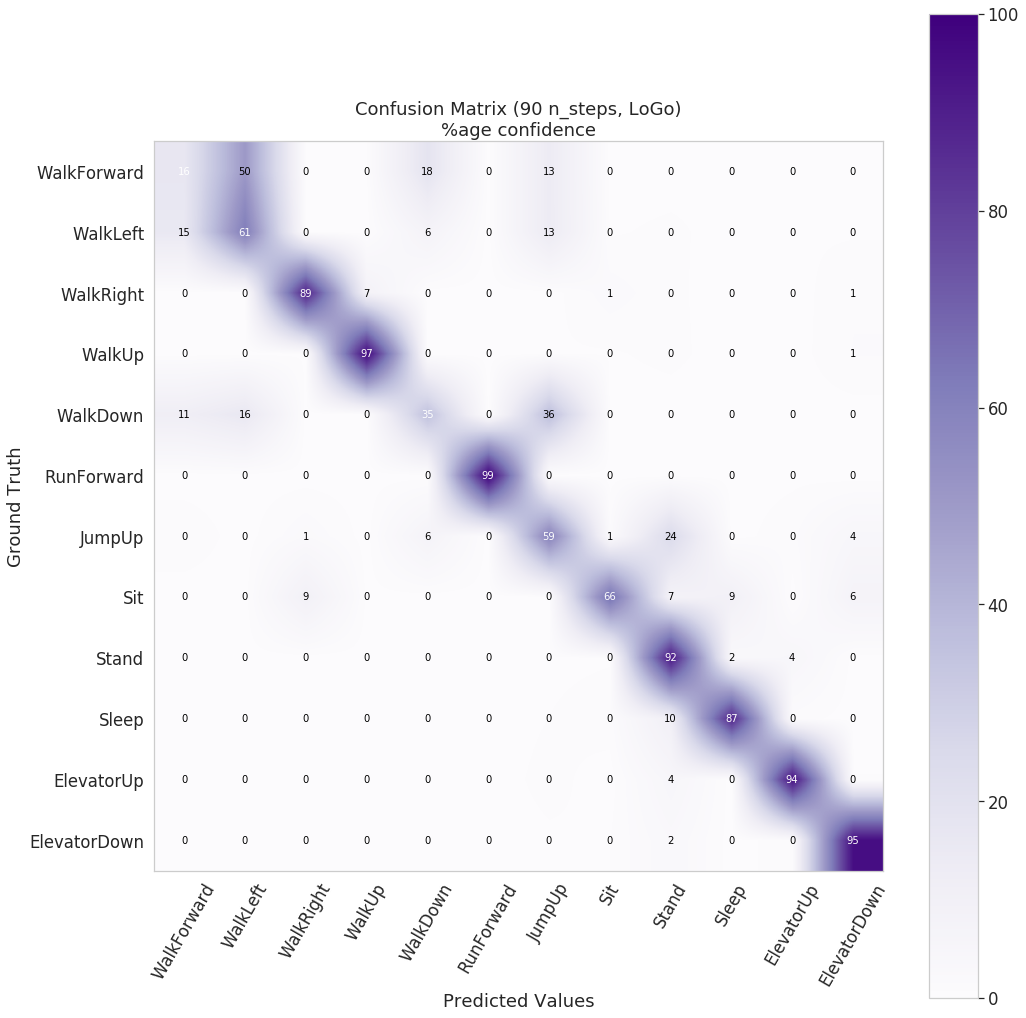

In [13]:
# %%pixie_debugger
# -*- coding: utf-8 -*-
'''
Evaluate a pretrained model saved as *.h5 using 'testData_X.npy'
and 'groundTruth_X.npy'. Error reported is the cross entropy loss in percentage. Also generates a png file for the confusion matrix.
Based on work by Muhammad Shahnawaz.

NOTE: keep in mind we are only looking at Model 14 given our 'logo' approach! 
'''

if not os.path.exists('./plots'):
    os.makedirs('./plots')

## define a function for plotting the confusion matrix
## takes cmNormalized
os.environ['QT_PLUGIN_PATH'] = ''
def plot_cm(cM, labels,title):
    
    plt.close()
    ## normalizing the confusionMatrix for showing the probabilities
    cmNormalized = np.around((cM/cM.astype(np.float).sum(axis=1)[:,None])*100,2)
    ## creating a figure object
    fig = plt.figure(figsize=(15,15))
    ## plotting the confusion matrix
    plt.imshow(cmNormalized,interpolation='bilinear',cmap = plt.cm.Purples)
    ## creating a color bar and setting the limits
    plt.colorbar()
    plt.clim(0,100)
    ## assiging the title, x and y labels
    plt.xlabel('Predicted Values')
    plt.ylabel('Ground Truth')
    plt.title(title + '\n%age confidence')
    ## defining the ticks for the x and y axis
    plt.xticks(range(len(labels)),labels,rotation = 60)
    plt.yticks(range(len(labels)),labels)
    ## number of occurences in the boxes
    width, height = cM.shape
    print('Accuracy for each class is given below.')
    for predicted in range(width):
        for real in range(height):
            color = 'black'
            if(predicted == real):
                color = 'white'
                print(labels[predicted].ljust(12)+ ':', cmNormalized[predicted,real], '%')
            plt.gca().annotate(
                    '{:d}'.format(int(cmNormalized[predicted,real])),xy=(real, predicted),
                    horizontalalignment = 'center',verticalalignment = 'center',color = color)

    ## making sure that the figure is not clipped
    plt.tight_layout()
    plt.grid('off')
    ## save the figure
    fig.savefig(title +'.png')
    
## loading the pretrained model
model = load_model('./data/model_had_lstm_logo.h5')

## load weights into new model
model.load_weights('./data/model_weights_had_lstm_logo.h5')
print('Loaded model from disk')

## loading the testData and groundTruth data
test_x = np.load('./data/testData_had_lstm_logo.npy')
groundTruth = np.load('./data/groundTruth_had_lstm_logo.npy')

## evaluate loaded model on test data
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
score = model.evaluate(test_x,groundTruth,verbose=2)

## print out values for metrics
print('%s: %.2f%%' % (model.metrics_names[1], score[1]*100))
print('Baseline Error: %.2f%%' %(100-score[1]*100))

## Creating and plotting a confusion matrix

## defining the 12 class labels
labels = ['WalkForward','WalkLeft','WalkRight','WalkUp','WalkDown','RunForward', 'JumpUp', 'Sit', 'Stand', 'Sleep', 'ElevatorUp', 'ElevatorDown']

## predicting the classes
predictions = model.predict(test_x,verbose=2)

## getting the class predicted and class in ground truth for creation of confusion matrix
predictedClass = np.zeros((predictions.shape[0]))
groundTruthClass = np.zeros((groundTruth.shape[0]))

for instance in range (groundTruth.shape[0]):
    predictedClass[instance] = np.argmax(predictions[instance,:])
    groundTruthClass[instance] = np.argmax(groundTruth[instance,:])

cm = metrics.confusion_matrix(groundTruthClass,predictedClass)

print(cm)

## plotting the confusion matrix
plot_cm(cm, labels,'Confusion Matrix (90 n_steps, LoGo)')

print(model.summary())


['acc', 'loss', 'val_acc', 'val_loss']


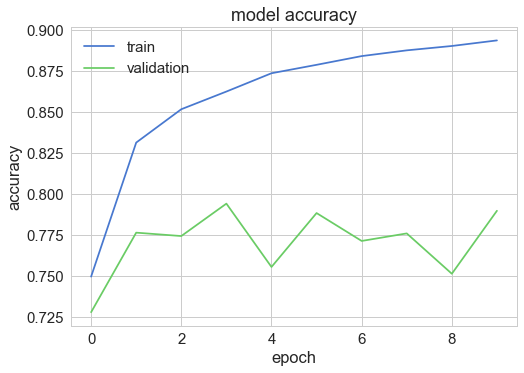

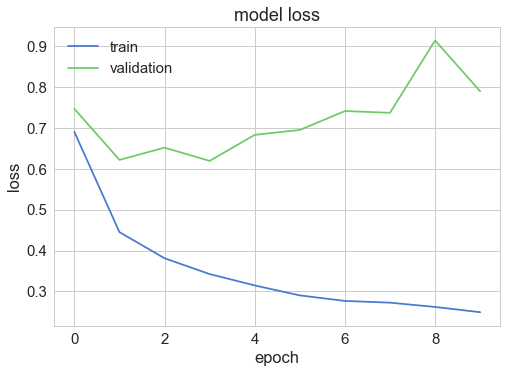

In [6]:
## plot acc and loss plot of last stored model weights in history variable

## load model history (models 1-14). Below we load the last 'logo' model 
history = pickle.load(open('./train_history/train_history_dict_0','rb'))

print(history.keys())

## plot train+val accuracy
plt.plot(history['acc'])
plt.plot(history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('./plots/acc_plot_logo.pdf', bbox_inches='tight')

## plot train+val loss
plt.plot(history['loss'])
plt.plot(history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()
plt.savefig('./plots/loss_plot_logo.pdf', bbox_inches='tight')

In [ ]:
# history.history['loss']
# print(history.model.evaluate(testX,testY,verbose=3))

### Freeze and inspect Keras model graphs

In [15]:
if not os.path.exists('./tensorflow_pb_models'):
    os.makedirs('./tensorflow_pb_models')

In [16]:
## function to find out input and output names of frozen graphs
def print_graph_nodes(filename):
    g = tf.GraphDef()
    g.ParseFromString(open(filename, 'rb').read())
    print()
    print(filename)
    print('=======================INPUT=========================')
    print([n for n in g.node if n.name.find('input') != -1])
    print('=======================OUTPUT========================')
    print([n for n in g.node if n.name.find('output') != -1])
    print('===================KERAS_LEARNING=====================')
    print([n for n in g.node if n.name.find('keras_learning_phase') != -1])
    print('======================================================')
    print()

In [20]:
## Freeze graphs: Method 1 
## NOTE: all frozen models are based on TrainSplit of 80%/20%, and not on LeaveOneGroupOut model (since we take the last one)

K.clear_session()

## this was created with @warptime's help. Thank you!

saved_model_path = './data/model_had_lstm_logo.h5'

model = load_model(saved_model_path)
nb_classes = 1 ## The number of output nodes in the model
prefix_output_node_names_of_final_network = 'output_node'

K.set_learning_phase(0)

pred = [None]*nb_classes
pred_node_names = [None]*nb_classes
for i in range(nb_classes):
    pred_node_names[i] = prefix_output_node_names_of_final_network+str(i)
    pred[i] = tf.identity(model.output[i], name=pred_node_names[i])
print('output nodes names are: ', pred_node_names)

sess = K.get_session()
output_fld = 'tensorflow_pb_models/'
if not os.path.isdir(output_fld):
    os.mkdir(output_fld)
output_graph_name = 'model_had_lstm_logo' + '.pb'
output_graph_suffix = '_inference'

constant_graph = graph_util.convert_variables_to_constants(sess, sess.graph.as_graph_def(), pred_node_names)
graph_io.write_graph(constant_graph, output_fld, output_graph_name, as_text=False)
print('saved the constant graph (ready for inference) at: ', osp.join(output_fld, output_graph_name))

output nodes names are:  ['output_node0']
INFO:tensorflow:Froze 10 variables.
INFO:tensorflow:Converted 10 variables to const ops.
saved the constant graph (ready for inference) at:  tensorflow_pb_models/model_had_lstm_logo.pb


In [21]:
## Method 1 inspect output

print_graph_nodes('./tensorflow_pb_models/model_had_lstm_logo.pb')
# print_graph_nodes('./graph_test/output_graph.pb')


./tensorflow_pb_models/model_had_lstm_logo.pb
=======================INPUT=========================
[name: "keras_learning_phase/input"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_BOOL
  }
}
attr {
  key: "value"
  value {
    tensor {
      dtype: DT_BOOL
      tensor_shape {
      }
      bool_val: false
    }
  }
}
, name: "conv_lst_m2d_14_input"
op: "Placeholder"
attr {
  key: "dtype"
  value {
    type: DT_FLOAT
  }
}
attr {
  key: "shape"
  value {
    shape {
      dim {
        size: -1
      }
      dim {
        size: -1
      }
      dim {
        size: 90
      }
      dim {
        size: 6
      }
      dim {
        size: 1
      }
    }
  }
}
]
=======================OUTPUT========================
[name: "output_node0"
op: "Identity"
input: "strided_slice"
attr {
  key: "T"
  value {
    type: DT_FLOAT
  }
}
]
===================KERAS_LEARNING=====================
[name: "keras_learning_phase/input"
op: "Const"
attr {
  key: "dtype"
  value {
    type: DT_B

In [ ]:
## Freeze graphs: Method 2

K.clear_session()

def freeze_session(session, keep_var_names=None, output_names=None, clear_devices=True):
    '''
    Freezes the state of a session into a pruned computation graph.

    Creates a new computation graph where variable nodes are replaced by
    constants taking their current value in the session. The new graph will be
    pruned so subgraphs that are not necessary to compute the requested
    outputs are removed.
    @param session The TensorFlow session to be frozen.
    @param keep_var_names A list of variable names that should not be frozen,
                          or None to freeze all the variables in the graph.
    @param output_names Names of the relevant graph outputs.
    @param clear_devices Remove the device directives from the graph for better portability.
    @return The frozen graph definition.
    '''
    
    from tensorflow.python.framework.graph_util import convert_variables_to_constants
    graph = session.graph
    with graph.as_default():
        freeze_var_names = list(set(v.op.name for v in tf.global_variables()).difference(keep_var_names or []))
        output_names = output_names or []
        output_names += [v.op.name for v in tf.global_variables()]
        input_graph_def = graph.as_graph_def()
        if clear_devices:
            for node in input_graph_def.node:
                node.device = ''
        frozen_graph = convert_variables_to_constants(session, input_graph_def,
                                                      output_names, freeze_var_names)
        return frozen_graph

## create, compile and train model
K.set_learning_phase(0)

# model = 'model_ucd.h5'
model = load_model('./tensorflow_pb_models/model_ucd.h5')

# tf.reset_default_graph()
frozen_graph = freeze_session(K.get_session(), output_names=[out.op.name for out in model.outputs])
tf.train.write_graph(frozen_graph, './tensorflow_pb_models/', 'ucd_model_test2.pb', as_text=False)

In [ ]:
## method 2 inspect output
print_graph_nodes('./tensorflow_pb_models/ucd_model_test2.pb')

In [ ]:
## freeze graphs: Method 3 - using freeze_graph.py

K.clear_session()

K.set_learning_phase(0)
model = load_model('model_hcd_test.h5')
print(model.output.op.name)
saver = tf.train.Saver()
saver.save(K.get_session(), '/tmp/keras_model_test.ckpt')

In [ ]:
!python -W ignore /Users/aelali/anaconda/lib/python2.7/site-packages/tensorflow/python/tools/freeze_graph.py --input_meta_graph=/tmp/keras_model_test.ckpt.meta \
--input_checkpoint=/tmp/keras_model_test.ckpt --output_graph=./tensorflow_model/ucd_keras_frozen3_TEST.pb --output_node_names='OUTPUT/truediv' --input_binary=true

In [ ]:
## method 3 inspect output
print_graph_nodes('./tensorflow_pb_models/ucd_keras_frozen3_test.pb')

In [ ]:
## freeze graphs: Method 4

model = load_model('./tensorflow_pb_models/model_hcd_test.h5')
# model.load_weights('model_weights_ucd.h5')
 
## all new operations will be in test mode from now on
K.set_learning_phase(0)
 
## serialize the model and get its weights, for quick re-building
config = model.get_config()
weights = model.get_weights()
 
## re-build a model where the learning phase is now hard-coded to 0
new_model = Sequential.from_config(config)
new_model.set_weights(weights)
 
temp_dir = 'graph_test'
checkpoint_prefix = os.path.join(temp_dir, 'saved_checkpoint')
checkpoint_state_name = 'checkpoint_state'
input_graph_name = 'input_graph.pb'
output_graph_name = 'output_graph.pb'
 
## temporary save graph to disk without weights included
saver = tf.train.Saver()
checkpoint_path = saver.save(K.get_session(), checkpoint_prefix, global_step=0, latest_filename=checkpoint_state_name)
tf.train.write_graph(K.get_session().graph, temp_dir, input_graph_name)
 
input_graph_path = os.path.join(temp_dir, input_graph_name)
input_saver_def_path = ''
input_binary = False
output_node_names = 'OUTPUT/truediv' # model dependent (e.g., Softmax)
restore_op_name = 'save/restore_all'
filename_tensor_name = 'save/Const:0'
output_graph_path = os.path.join(temp_dir, output_graph_name)
clear_devices = False
 
## embed weights inside the graph and save to disk
freeze_graph.freeze_graph(input_graph_path, input_saver_def_path,
                          input_binary, checkpoint_path,
                          output_node_names, restore_op_name,
                          filename_tensor_name, output_graph_path,
                          clear_devices, '')

### Inspect graphs with TensorBoard 

In [ ]:
## visualize using tensorboard
import webbrowser

tf.logging.set_verbosity(tf.logging.ERROR)
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

## convert the model to tensorboard viz
!python -W ignore /Users/aelali/anaconda/lib/python2.7/site-packages/tensorflow/python/tools/import_pb_to_tensorboard.py --model_dir ~/Desktop/HAR-CNN-Keras/tensorflow_pb_models/model_ucd.h5.pb --log_dir /tmp/tensorflow_logdir 

## UNCOMMENT to run tensorboard on stated logdir
# !tensorboard --logdir /tmp/tensorflow_logdir

## go to tensorboard in your browser
# url = 'http://' + 'localhost:6006/'
# webbrowser.open(url)



In [ ]:
# !pip install pixiedust
# import pixiedust
# %%pixie_debugger

### Test if your frozen model works as intended

In [ ]:
## define a function to load the frozen graph

def load_graph(frozen_graph_filename):
    ## load the protobuf file from the disk and parse it to retrieve the unserialized graph_def
    with tf.gfile.GFile(frozen_graph_filename, 'rb') as f:
        graph_def = tf.GraphDef()
        graph_def.ParseFromString(f.read())

    ## import the graph_def into a new Graph and returns it 
    with tf.Graph().as_default() as graph:
        ## graph var will prefix every op/nodes in your graph
        ## since we load everything in a new graph, this is not needed
        tf.import_graph_def(graph_def, name='prefix')
    return graph

In [ ]:
## load the graph using the 'load_graph' function
graph = load_graph('/Users/aelali/Desktop/HAR-CNN-Keras/tensorflow_pb_models/model_ucd.h5.pb')

## verify that we can access the list of operations in the graph
for op in graph.get_operations():
    print(op.name)    

In [ ]:
## now test if the frozen model performs predictions as intended

## get the input and output nodes 
x = graph.get_tensor_by_name('prefix/conv2d_1_input:0')
y = graph.get_tensor_by_name('prefix/dense_3/Softmax:0')

## launch tf session
with tf.Session(graph=graph) as sess:
    ## note: we don't need to initialize/restore anything
    ## there are no vars in this graph, only hardcoded constants 
    y_out = sess.run(y, feed_dict={
        x: testX[[100]] # < 45
    })
    
    l = np.round(testY[[100]])
    print('label: ' + str(l))
    z = (np.round(y_out)).astype(int)
    print('prediction: ' + str(z))
    
    print('prediction correct? ' + str(np.array_equal(l,z)))

### Check mismatch between sensor readings of dataset and Android sensors

sitting mean usc-had acc_x: 0.8275517870451022
sitting std usc-had acc_x: 0.08702539053000118
sitting mean usc-had acc_y: 0.47151391545812116
sitting std usc-had acc_y: 0.1771941735702898
sitting mean usc-had acc_z: 0.19264190885658336
sitting std usc-had acc_z: 0.17058384939588664
sitting mean usc-had gyr_x: 0.19264190885658336
sitting std usc-had gyr_x: 0.17058384939588664
sitting mean usc-had gyr_y: 0.19264190885658336
sitting std usc-had gyr_y: 3.505542665706356
sitting mean usc-had gyr_z: 0.09090915439847408
sitting std usc-had gyr_z: 4.136471407581966


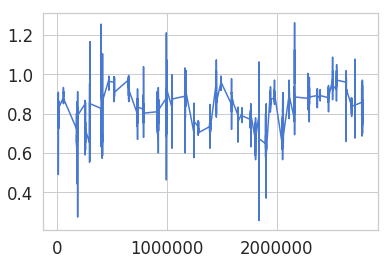

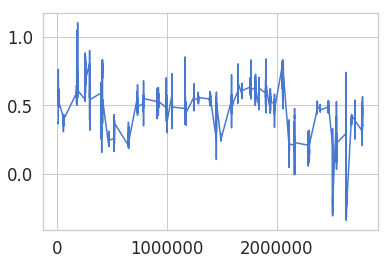

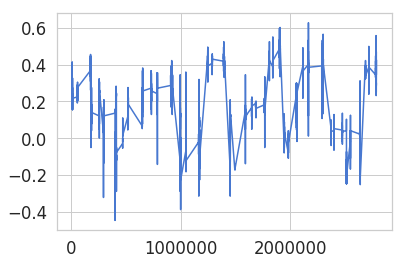

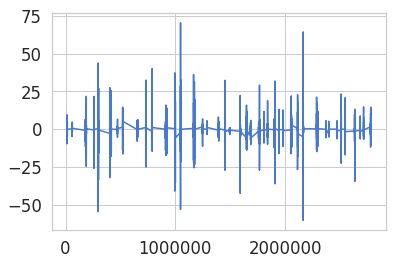

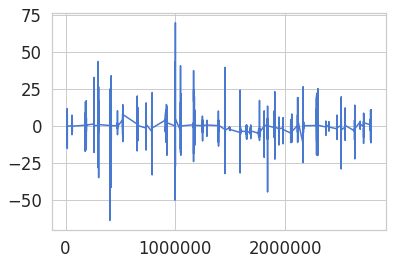

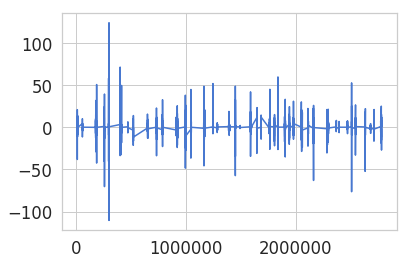

In [26]:
## USC-HAD dataset inspect

len_sample = len(df)

# print(df[df['activity'] == 'Sitting']['acc_x'])
usc_sit_df_acc_x = df[df['activity'] == 'Sitting']['acc_x'][0:len_sample]
usc_sit_df_acc_y = df[df['activity'] == 'Sitting']['acc_y'][0:len_sample]
usc_sit_df_acc_z = df[df['activity'] == 'Sitting']['acc_z'][0:len_sample]
usc_sit_df_gyr_x = df[df['activity'] == 'Sitting']['gyr_x'][0:len_sample]
usc_sit_df_gyr_y = df[df['activity'] == 'Sitting']['gyr_y'][0:len_sample]
usc_sit_df_gyr_z = df[df['activity'] == 'Sitting']['gyr_z'][0:len_sample]


print('sitting mean usc-had acc_x: '+ str(np.mean(usc_sit_df_acc_x)))
print('sitting std usc-had acc_x: '+ str(np.std(usc_sit_df_acc_x)))

print('sitting mean usc-had acc_y: '+ str(np.mean(usc_sit_df_acc_y)))
print('sitting std usc-had acc_y: '+ str(np.std(usc_sit_df_acc_y)))

print('sitting mean usc-had acc_z: '+ str(np.mean(usc_sit_df_acc_z)))
print('sitting std usc-had acc_z: '+ str(np.std(usc_sit_df_acc_z)))

print('sitting mean usc-had gyr_x: '+ str(np.mean(usc_sit_df_acc_z)))
print('sitting std usc-had gyr_x: '+ str(np.std(usc_sit_df_acc_z)))

print('sitting mean usc-had gyr_y: '+ str(np.mean(usc_sit_df_acc_z)))
print('sitting std usc-had gyr_y: '+ str(np.std(usc_sit_df_gyr_y)))

print('sitting mean usc-had gyr_z: '+ str(np.mean(usc_sit_df_gyr_z)))
print('sitting std usc-had gyr_z: '+ str(np.std(usc_sit_df_gyr_z)))


# print 'usc-had dataset acc_x sample for sitting activity: '+ str(np.mean(sit_df_acc_x))
plt.plot(usc_sit_df_acc_x)
plt.show()
plt.plot(usc_sit_df_acc_y)
plt.show()
plt.plot(usc_sit_df_acc_z)
plt.show()
plt.plot(usc_sit_df_gyr_x)
plt.show()
plt.plot(usc_sit_df_gyr_y)
plt.show()
plt.plot(usc_sit_df_gyr_z)
plt.show()

sitting android acc_x size: 300
sitting mean android acc_x: 5.795021454333334
sitting std android acc_x: 0.1546386070887035
sitting mean android acc_y: 3.5278160356666666
sitting std android acc_y: 0.35885386975185224
sitting mean android acc_z: 7.550522920333333
sitting std android acc_z: 0.2383939497187787
sitting mean android gyr_x: -0.019029214404346663
sitting std android gyr_x: 0.07544860409278752
sitting mean android gyr_y: -0.008958773748733334
sitting std android gyr_y: 0.04664604581057123
sitting mean android gyr_z: -0.020935697682131
sitting std android gyr_z: 0.07335605288544335


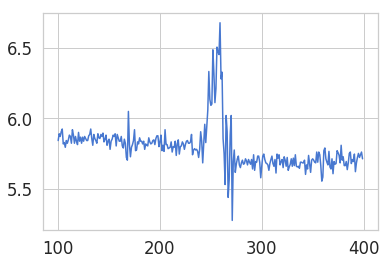

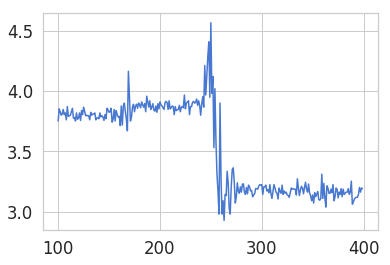

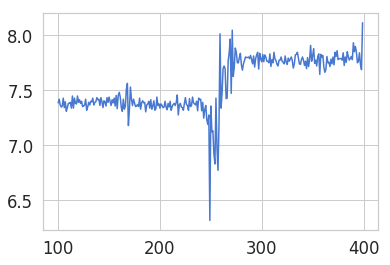

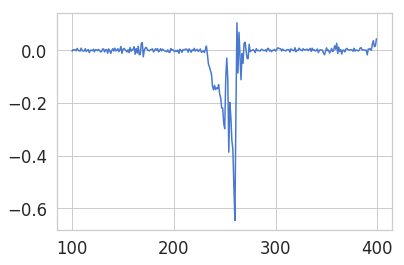

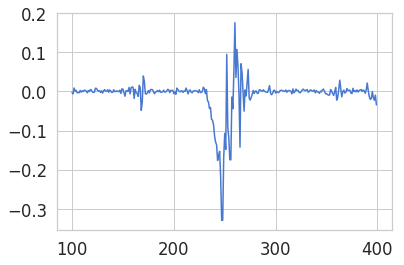

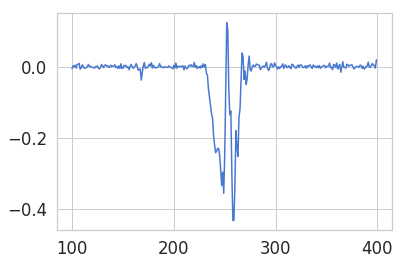

In [27]:
## Android sensor reading samples inspect

acc_sit_android = pd.read_csv('./data/android_sitting_acc.csv')[100:400]
gyr_sit_android = pd.read_csv('./data/android_sitting_gyr.csv')[100:400]

sit_acc_x = acc_sit_android['X']
sit_acc_y = acc_sit_android['Y']
sit_acc_z = acc_sit_android['Z']
sit_gyr_x = gyr_sit_android['X']
sit_gyr_y = gyr_sit_android['Y']
sit_gyr_z = gyr_sit_android['Z']

print('sitting android acc_x size: '+ str(len(sit_acc_x)))

print('sitting mean android acc_x: '+ str(np.mean(sit_acc_x)))
print('sitting std android acc_x: '+ str(np.std(sit_acc_x)))

print('sitting mean android acc_y: '+ str(np.mean(sit_acc_y)))
print('sitting std android acc_y: '+ str(np.std(sit_acc_y)))

print('sitting mean android acc_z: '+ str(np.mean(sit_acc_z)))
print('sitting std android acc_z: '+ str(np.std(sit_acc_z)))

print('sitting mean android gyr_x: '+ str(np.mean(sit_gyr_x)))
print('sitting std android gyr_x: '+ str(np.std(sit_gyr_x)))

print('sitting mean android gyr_y: '+ str(np.mean(sit_gyr_y)))
print('sitting std android gyr_y: '+ str(np.std(sit_gyr_y)))

print('sitting mean android gyr_z: '+ str(np.mean(sit_gyr_z)))
print('sitting std android gyr_z: '+ str(np.std(sit_gyr_z)))


plt.plot(sit_acc_x)
plt.show()
plt.plot(sit_acc_y)
plt.show()
plt.plot(sit_acc_z)
plt.show()
plt.plot(sit_gyr_x)
plt.show()
plt.plot(sit_gyr_y)
plt.show()
plt.plot(sit_gyr_z)
plt.show()